In [9]:
import pickle
import torch
import numpy as np
import collections
import torch.optim as optim 
import torch.nn.functional as F 
from utils import get_topwords, plot_fig
from plsv_vae_beta_param import PlsvVAE
from sklearn.feature_extraction.text import CountVectorizer

In [3]:

with open('data/reuters/preprossed_data.pkl', 'rb') as f: 
    preprossed_data = pickle.load(f)

with open('data/reuters/data_reuters_labels.pkl', 'rb') as f:
    train_label = pickle.load(f)

vectorizer = CountVectorizer(min_df=9)
train_vec = vectorizer.fit_transform(preprossed_data).toarray()
vocab = vectorizer.vocabulary_
nonzeros_indexes = np.where(train_vec.any(1))[0]
train_vec_non_zeros = [train_vec[i] for i in nonzeros_indexes]


train_vec = np.array(train_vec_non_zeros)
print(len(train_vec))
print(len(train_label))
print(len(vocab))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tensor_train_w = torch.from_numpy(np.array(train_vec)).float()
train_label = np.asarray(train_label)

id_vocab = dict(map(reversed, vocab.items()))
num_coordinate = 2
bs = 256
en1_units_x = 100
en2_units_x = 100
num_input = train_vec[0].shape[0]
variance_x = 1
learning_rate = 0.002
beta1 = 0.99
beta2 = 0.999
drop_rate = 0.6
num_topic = 50

7674
7674
3062


## Train

In [4]:
model = PlsvVAE(num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs, "inverse_quadratic")
model.to(device)
optimizer = optim.Adam(model.parameters(), learning_rate, betas=(beta1, beta2))
epochs = 100
phi_arr = []
beta_arr = []
x_arr = []
recon_arr = []
list_d = []
all_indices = torch.randperm(tensor_train_w.size(0)).split(bs)

for epoch in range(epochs):

    loss_u_epoch = 0.0
    loss_xkl_epoch = 0.0
    loss_betakl_epoch = 0.0
    loss_phikl_epoch = 0.0
    loss_KLD = 0.0
    loss_phi_epoch = 0.0
    recon_ep = 0.0
    loss_epoch = 0.0
    model.train()
    d_temp = []

    for batch_ndx in all_indices:

        input_w = tensor_train_w[batch_ndx].to(device)
        labels = train_label[batch_ndx]
        input_c = None
        recon_v, (loss, loss_u, xkl_loss, kl) = model(input_w, compute_loss=True)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()             # backpror.step()            # update parameters
        loss_epoch += loss.item()
        loss_u_epoch += loss_u.item()
        loss_xkl_epoch += xkl_loss.item() 
        loss_KLD += kl.item() #/ len(tensor_train_w)) 
        recon_ep += recon_v.mean().item() 

    x_arr.append(loss_xkl_epoch)
    recon_arr.append(loss_u_epoch)

    if epoch % 10 == 0:
        print('Epoch {}, loss={}'.format(epoch, loss_epoch))
        print('x_loss={}, recon_loss={}, KLD= {}'.format(loss_xkl_epoch, loss_u_epoch, loss_KLD)) 

E:\source_code\plsv_vae2\plsv_vae_beta_param.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  recon_v = torch.mm(zx_phi, F.softmax(self.beta))


Epoch 0, loss=14619.462921142578
x_loss=46.77958261966705, recon_loss=3739596.7265625, KLD= 46.77958261966705
Epoch 10, loss=13560.785858154297
x_loss=69.58673655986786, recon_loss=3468759.6875, KLD= 69.58673655986786
Epoch 20, loss=12804.158386230469
x_loss=36.17005789279938, recon_loss=3275242.71875, KLD= 36.17005789279938
Epoch 30, loss=12167.331787109375
x_loss=85.14187741279602, recon_loss=3112287.3125, KLD= 85.14187741279602
Epoch 40, loss=11778.75537109375
x_loss=186.6762990951538, recon_loss=3012783.453125, KLD= 186.6762990951538
Epoch 50, loss=11527.490142822266
x_loss=286.1840982437134, recon_loss=2948413.2265625, KLD= 286.1840982437134
Epoch 60, loss=11414.286529541016
x_loss=332.0499687194824, recon_loss=2919409.140625, KLD= 332.0499687194824
Epoch 70, loss=11369.520935058594
x_loss=340.2077693939209, recon_loss=2907952.0546875, KLD= 340.2077693939209
Epoch 80, loss=11345.5888671875
x_loss=341.3435583114624, recon_loss=2901830.1875, KLD= 341.3435583114624
Epoch 90, loss=113

## Test beta and visualization

In [19]:
model.eval()
x_list = []
phi_list = []
beta_list = []
labels_list = []
with torch.no_grad():
    for batch_ndx in all_indices:
        input_w = tensor_train_w[batch_ndx].to(device)
        labels = train_label[batch_ndx]
        labels_list.extend(labels)
        z, recon_v, zx, zx_phi = model(input_w, compute_loss=False)
        zx = zx.view(-1, num_coordinate).data.detach().cpu().numpy()
        x_list.extend(zx)

    x_list = np.array(x_list)

    #beta = model.decoder.weight.data.cpu().numpy().T#
    beta = F.softmax(model.beta).data.cpu().numpy()#
    zphi = model.decoder_phi_bn(model.centres).data.cpu().numpy()
    print("---"*10)
    topword_topics = get_topwords(beta, id_vocab)
    for topwords in topword_topics:
        print(topwords)
    print("---"*10)


------------------------------
0: mln ct net shr loss dlr reuter profit qtr rev
1: record reuter ct shr set april mln dividend one inc
2: declar turnov free pre ship remain transport guilder initi vessel
3: ship free british declar remain vessel enterpris water turnov ferri
4: said dlr share compani mln reuter pct inc corp stock
5: free ship declar western vessel ferri final enterpris transport water
6: ship free ferri vessel enterpris water peopl british tonn western
7: ferri vessel enterpris water ship peopl free coast belgian channel
8: record ct net reuter shr mln one dlr april set
9: vessel ferri enterpris free water ship peopl belgian reuter herald
10: free ship british vessel ferri water declar enterpris januari fourth
11: said reuter dlr mln year pct compani would ct net
12: free ship ferri vessel enterpris british water peopl declar western
13: record reuter ct set net mln one loss inc april
14: declar parent guilder decemb turnov final contract compar rose fourth
15: said tra

E:\anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


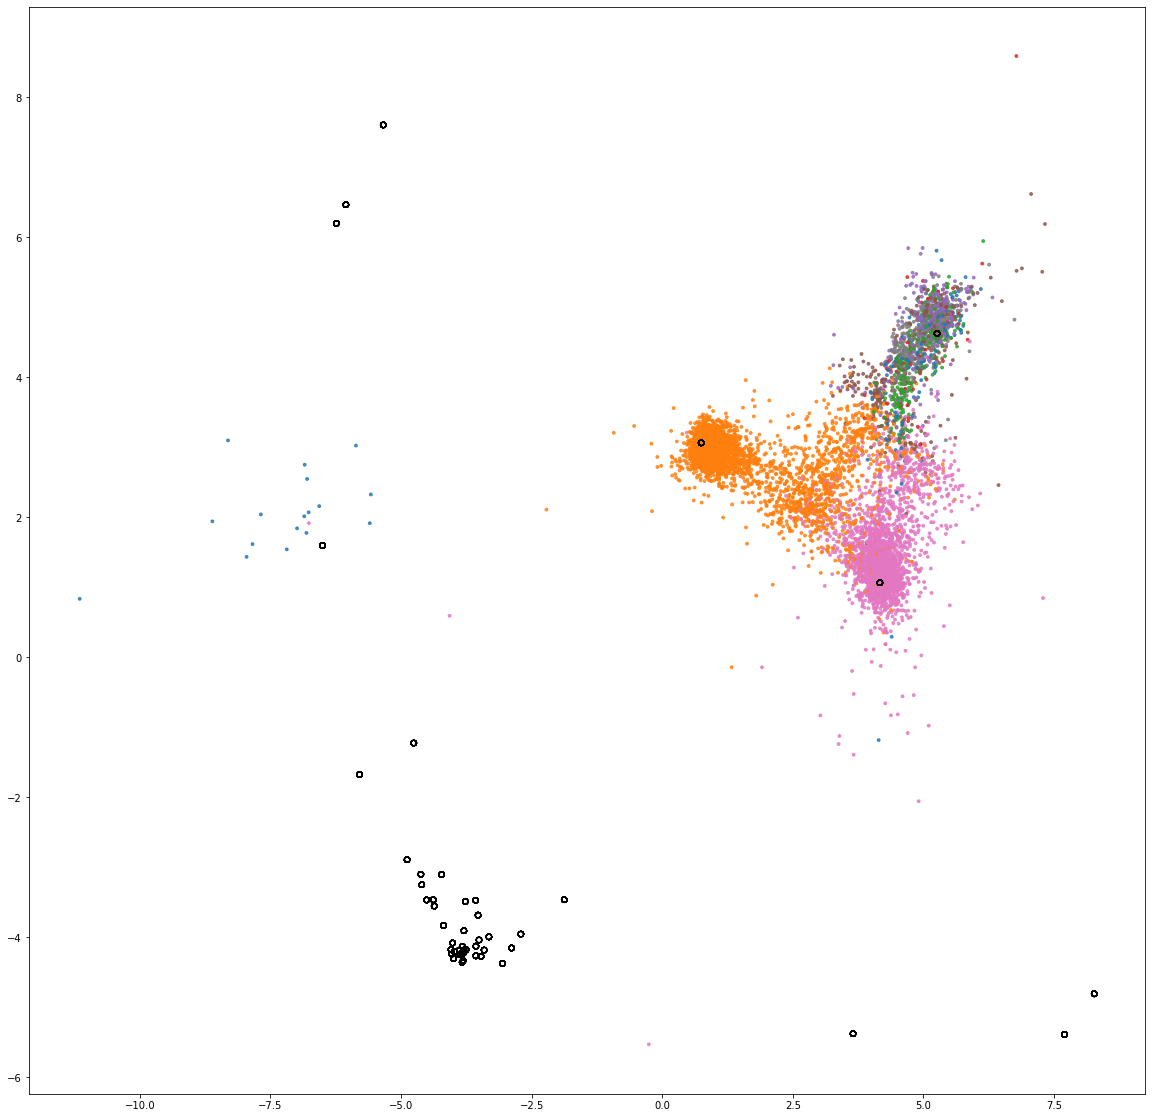

In [20]:
categories = {'ship': 'C0',
             'earn': 'C1',
             'interest': 'C2',
             'grain': 'C3',
             'trade': 'C4',
             'crude': 'C5',
             'acq': 'C6',
             'money-fx': 'C7'}
plot_fig(x_list, labels_list, categories, zphi)

In [6]:
beta.shape

torch.Size([50, 3062])